In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.tensor import fft

X_new_temp,muJ_temp,sdJ_temp = np.loadtxt('Jband.txt', delimiter=',', usecols=(0,1,2), unpack=True)
XK_new_temp,muK_temp,sdK_temp = np.loadtxt('Kband.txt', delimiter=',', usecols=(0,1,2), unpack=True)

X_new=X_new_temp[0:99]
muJ=muJ_temp[0:99]
sdJ=sdJ_temp[0:99]

XK_new=XK_new_temp[0:99]
XK_new=np.reshape(XK_new,(1,1,99,1))
muK=muK_temp[0:99]
sdK=sdK_temp[0:99]

#difft = np.absolute(X_new-XK_new)

#print(difft.shape)
print(len(X_new))

99


In [14]:
def findMiddle(input_list):
    if len(input_list) % 2 != 0:
        return (int((len(input_list))/2)-1)
    else:
        return (int((len(input_list)/2)-1)-1,int((len(input_list))/2)-1)
# 1 is subtracted from both because python indicies start at 0 

In [3]:
def Middlearray(input_list, data):
    mid = findMiddle(input_list)
    
    if isinstance(mid, int) == False:#if there is two mid values
        li = input_list
        limid=li[int(mid[0]-(len(data)/2)):mid[0]]
        limid2 = li[mid[1]:int(mid[1]+(len(data)/2))]
        convsame=np.hstack((limid,limid2))
    else:#if there is one mid value 
        li = input_list 
        convsame = li[int(mid-(len(data)/2)):int(mid+(len(data)/2))]
        
    
    if len(convsame) == len(data):
        return convsame
    else:
        return -inf


In [93]:
import theano
import theano.tensor as tt
import theano.tensor.signal.conv
from scipy import signal

with pm.Model() as convmodel:
    #Define priors
    sigma_DT=pm.Uniform('sigma_DT', lower=tt.log(2.0), upper=tt.log(500.0))#needs a source for scale
    sigma_AD=pm.Uniform('sigma_AD', lower=tt.log(2.0), upper=tt.log(500.0))#needs a source for scale
    mu_DT=pm.Uniform('mu_DT', lower=tt.log(10.0), upper=tt.log(1000.0))#we expect serveral tens to hundreds of days
    mu_AD=pm.Uniform('mu_AD', lower=tt.log(2.0), upper=tt.log(300.0))#AD has 3-5 times smaller lags than DT 
    A_T=pm.Uniform('A_T', lower=0.0, upper=1.0)#needs to be restricted between 0 to 1
    wav=pm.Uniform('wav', lower=tt.log(100.0), upper=tt.log(10000.0))#the range is large 
    T=pm.Uniform('T', lower=tt.log(1000.0), upper=tt.log(1700.0))#try a normal here instead
    K_0=pm.Uniform('K_0', lower=0.0, upper=10.0)#is it BB/powr or powr/BB?
    index=pm.Uniform('index', lower=0.0, upper=5.0)#the sign should be postive bacause of magnitudes

    #Define constants 
    wav_0 = 5000.0#Reference wavelength
    h = 6.626e-34#Plancks constant
    c = 299792458.0#speed of light
    k = 1.38e-23#Boltzmanns constant
    
    #Dusty Torus transfer equation
    wav_peak = 2.898*10**6/tt.exp(T)
    b_max = h*c/(1e-9*wav_peak*k*tt.exp(T))
    BB_max = 1.0/( (wav_peak**5) * (tt.exp(b_max) - 1.0) )
    b = h*c/(1e-9*tt.exp(wav)*k*tt.exp(T))
    BB = (1.0/( (tt.exp(wav)**5) * (tt.exp(b) - 1.0) ))/BB_max
    
    DTmode=tt.exp(mu_DT-sigma_DT**2)
    DTexp_max = -((tt.log(DTmode)-mu_DT)**2/(2*sigma_DT**2)) 
    DTfront_max = 1.0/(DTmode*sigma_DT*np.sqrt(2*np.pi))
    
    #DTmu_max=tt.log(1000.0)
    #DTsigma_max=tt.log(500.0)
    #DTexp_max = -((tt.log(XK_new)-DTmu_max)**2/(2*DTsigma_max**2)) 
    #DTfront_max = 1.0/(XK_new*DTsigma_max*np.sqrt(2*np.pi))
    DT_max = DTfront_max*tt.exp(DTexp_max)
    
    exp_DT = -((tt.log(XK_new)-mu_DT)**2/(2*sigma_DT**2))
    front_DT = A_T/(XK_new*sigma_DT*np.sqrt(2*np.pi))
    lognorm_DT = front_DT*np.exp(exp_DT)
    Psi_DT = BB*lognorm_DT/DT_max#/lognorm_DT.sum(axis=2)
    #Psi_DT_norm = Psi_DT/Psi_DT.sum(axis=0)
    
    #Accretion Disk transfer equation
        
    #K_0_max=10.0
    #wav_max=10000.0
    #index_max=5.0
    #powr_max=K_0_max*(wav_max/wav_0)**(index_max)
    powr = K_0*(tt.exp(wav)/wav_0)**(index)
    
    ADmode=tt.exp(mu_AD-sigma_AD**2)
    ADexp_max = -((tt.log(ADmode)-mu_AD)**2/(2*sigma_AD**2)) 
    ADfront_max = 1.0/(ADmode*sigma_AD*np.sqrt(2*np.pi))
    
    #ADmu_max=tt.log(300.0)
    #ADsigma_max=tt.log(500.0)
    #ADexp_max = -((tt.log(XK_new)-ADmu_max)**2/(2*ADsigma_max**2)) 
    #ADfront_max = 1.0/(XK_new*ADsigma_max*np.sqrt(2*np.pi))
    AD_max = ADfront_max*tt.exp(ADexp_max)
    
    exp_AD = -((tt.log(XK_new)-mu_AD)**2/(2*sigma_AD**2))
    front_AD = (1.0-A_T)/(XK_new*sigma_AD*np.sqrt(2*np.pi))
    lognorm_AD = front_AD*tt.exp(exp_AD)
    Psi_AD = powr*lognorm_AD/AD_max#/lognorm_AD.sum(axis=2)
    #Psi_AD_norm = Psi_AD/Psi_AD.sum(axis=0)
    #print(lognorm_AD.sum(axis=2).tag)
    
    #Full transfer equation
    transfer = (Psi_DT + Psi_AD)
    #transfernorm = transfer/transfer.sum(axis=2)
    
    #The convolution
    muJT=np.reshape(muJ,(1,1,99,1))
    #print(muJT)
    
    convol=theano.tensor.nnet.conv2d(muJT,transfer,border_mode='half')
    #print(len(convol[0,0,:,0].tag.test_value))
    
    #Define likelihood
    likelihood = pm.Normal('muK', mu=convol[0,0,:,0], sigma=sdK, observed=muK)#include noise boost factor again

    tracetransfer = pm.sample(2000, tune=1000)#tuning improves speed?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [index, K_0, T, wav, A_T, mu_AD, mu_DT, sigma_AD, sigma_DT]
Sampling 4 chains: 100%|██████████| 12000/12000 [02:16<00:00, 87.92draws/s] 
The acceptance probability does not match the target. It is 0.6269375650823684, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
sigma_DT  3.410313  1.541279  0.027688  0.992895  6.192475  3083.187355   
sigma_AD  3.383708  1.586032  0.030944  0.850075  6.061334  1262.395688   
mu_DT     4.612228  1.297123  0.019705  2.522749  6.853636  3990.204877   
mu_AD     3.334454  1.512611  0.055151  0.917211  5.668098   136.694607   
A_T       0.472697  0.300536  0.010218  0.029042  0.974473   177.642664   
wav       7.044607  1.395060  0.052543  4.868563  9.208766   122.006738   
T         7.187593  0.155008  0.005060  6.938618  7.436504   198.369421   
K_0       5.183649  2.922579  0.084482  0.180733  9.601935   292.446415   
index     2.645957  1.530031  0.055917  0.236999  4.992823   138.735098   

              Rhat  
sigma_DT  1.000926  
sigma_AD  1.004499  
mu_DT     1.000193  
mu_AD     1.017320  
A_T       1.011886  
wav       1.020598  
T         1.009899  
K_0       1.008022  
index     1.016557

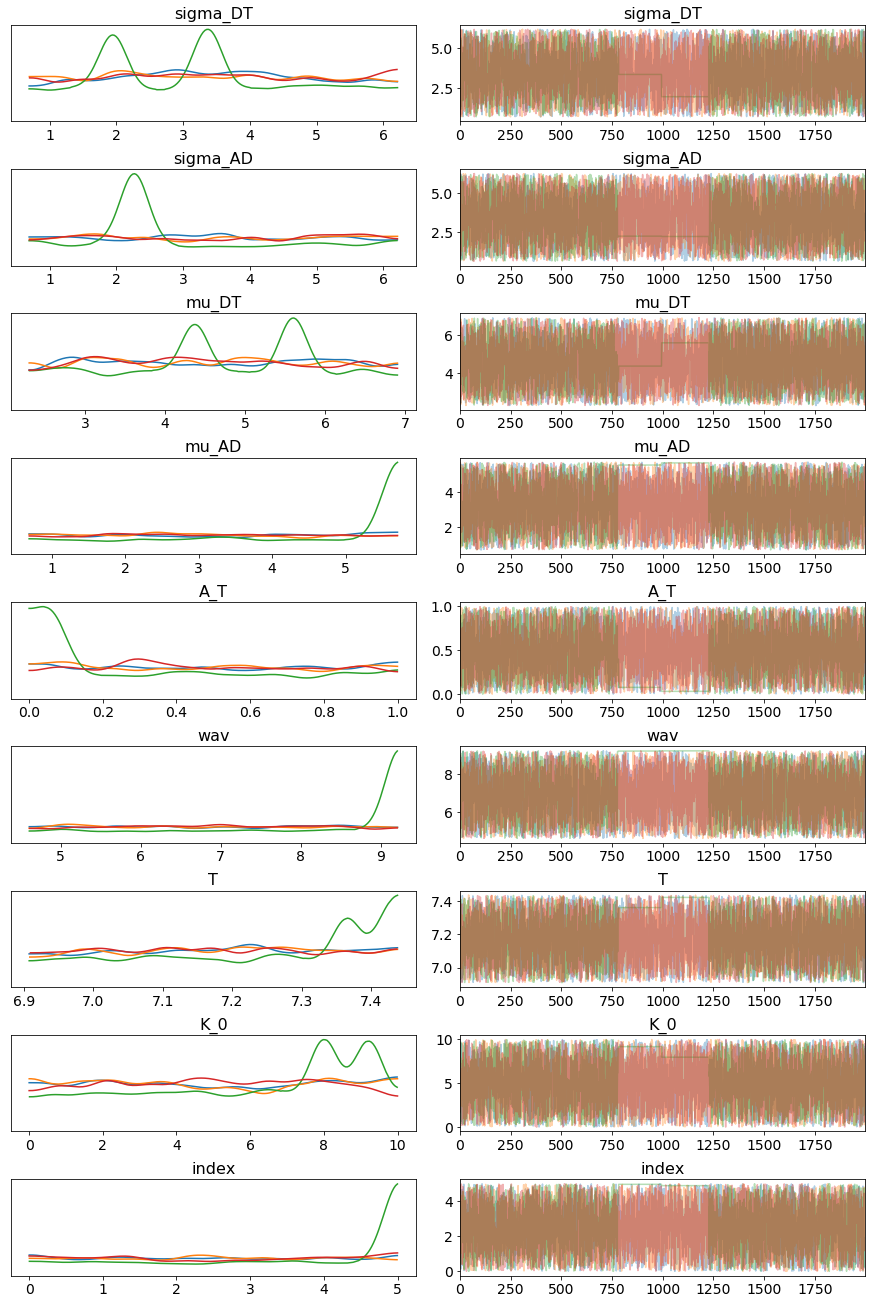

In [94]:
pm.traceplot(tracetransfer)
pm.summary(tracetransfer)

In [50]:
summ=pm.summary(tracetransfer)
print(summ.loc[:,'mean'])

sigma_DT    3.324727
sigma_AD    2.051806
mu_DT       4.576314
mu_AD       2.772664
A_T         0.501069
wav         8.549609
T           7.180623
K_0         3.384501
index      -2.465522
Name: mean, dtype: float64


In [91]:
sigma_DT=3.015820
sigma_AD=2.622087
mu_DT=5.471840
mu_AD=2.918013
A_T=0.512631
wav= np.exp(7.204110)
T=7.193322
K_0=4.355379
index=2.212950
    
#Define constants 
wav_0 = 5000.0#Reference wavelength
h = 6.626e-34#Plancks constant
c = 299792458.0#speed of light
k = 1.38e-23#Boltzmanns constant
    
#Dusty Torus transfer equation
    
wav_peak = 2.898*10**6/np.exp(T)
b_max = h*c/(1e-9*wav_peak*k*np.exp(T))
BB_max = 1.0/( (wav_peak**5) * (np.exp(b_max) - 1.0) )
b = h*c/(1e-9*wav*k*np.exp(T))
BB = (1.0/( (wav**5) * (np.exp(b) - 1.0) ))/BB_max

#DTmu_max=np.log(1000.0)
#DTsigma_max=np.log(500.0)
#DTexp_max = -((np.log(XK_new)-DTmu_max)**2/(2*DTsigma_max**2)) 
#DTfront_max = 1.0/(XK_new*DTsigma_max*np.sqrt(2*np.pi))
#DT_max = DTfront_max*np.exp(DTexp_max)

DT_exp_max=-(1/(2*sigma_DT**2))
DT_front_max=1.0/(np.exp(mu_DT-sigma_DT**2)*sigma_DT*np.sqrt(2*np.pi))
DT_lognorm_max=DT_front_max*np.exp(DT_exp_max)
    
exp_DT = -((np.log(XK_new)-mu_DT)**2/(2*sigma_DT**2))
front_DT = A_T/(XK_new*sigma_DT*np.sqrt(2*np.pi))
lognorm_DT =front_DT*np.exp(exp_DT) 
Psi_DT = BB*lognorm_DT/DT_lognorm_max#/np.sum(lognorm_DT)
#Psi_DT_norm = Psi_DT/np.sum(Psi_DT)
    
#Accretion Disk transfer equation

#K_0_max=10.0
#wav_max=10000.0
#index_max=5.0
#powr_max=K_0_max*(wav_max/wav_0)**(index_max)
powr = K_0*(wav/wav_0)**(index)
    
#ADmu_max=np.log(300.0)
#ADsigma_max=np.log(500.0)
#ADexp_max = -((np.log(XK_new)-ADmu_max)**2/(2*ADsigma_max**2)) 
#ADfront_max = 1.0/(XK_new*ADsigma_max*np.sqrt(2*np.pi))
#AD_max = ADfront_max*np.exp(ADexp_max)

AD_exp_max=-(1/(2*sigma_AD**2))
AD_front_max=1.0/(np.exp(mu_AD-sigma_AD**2)*sigma_AD*np.sqrt(2*np.pi))
AD_lognorm_max=AD_front_max*np.exp(AD_exp_max)

exp_AD = -((np.log(XK_new)-mu_AD)**2/(2*sigma_AD**2))
front_AD = (1.0-A_T)/(XK_new*sigma_AD*np.sqrt(2*np.pi))
lognorm_AD = front_AD*np.exp(exp_AD)
Psi_AD = powr*lognorm_AD/AD_lognorm_max#/np.sum(lognorm_AD)
#Psi_AD_norm = Psi_AD/np.sum(Psi_AD)

#Full transfer equation
transfer = (Psi_DT + Psi_AD)
#transfernorm = transfer/np.sum(transfer)
print(Psi_DT[0,0,:,0])
#print(lognorm_AD[0,0,:,0])
#print(np.sum(transfer[0,0,:,0])-np.sum(transfer))
#print(np.exp(mu_AD-sigma_AD**2))

[0.00111142 0.00111116 0.00111089 0.00111063 0.00111036 0.00111009
 0.00110983 0.00110956 0.0011093  0.00110904 0.00110877 0.00110851
 0.00110824 0.00110798 0.00110771 0.00110745 0.00110718 0.00110692
 0.00110666 0.00110639 0.00110613 0.00110587 0.0011056  0.00110534
 0.00110508 0.00110481 0.00110455 0.00110429 0.00110402 0.00110376
 0.0011035  0.00110323 0.00110297 0.00110271 0.00110245 0.00110219
 0.00110192 0.00110166 0.0011014  0.00110114 0.00110088 0.00110061
 0.00110035 0.00110009 0.00109983 0.00109957 0.00109931 0.00109905
 0.00109879 0.00109852 0.00109826 0.001098   0.00109774 0.00109748
 0.00109722 0.00109696 0.0010967  0.00109644 0.00109618 0.00109592
 0.00109566 0.0010954  0.00109514 0.00109488 0.00109462 0.00109436
 0.00109411 0.00109385 0.00109359 0.00109333 0.00109307 0.00109281
 0.00109255 0.00109229 0.00109204 0.00109178 0.00109152 0.00109126
 0.001091   0.00109075 0.00109049 0.00109023 0.00108997 0.00108971
 0.00108946 0.0010892  0.00108894 0.00108869 0.00108843 0.0010

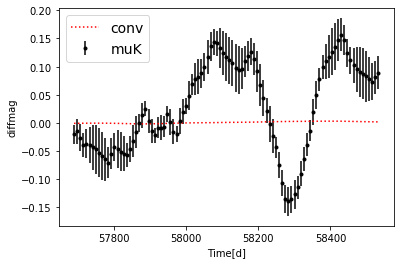

In [92]:
conv = signal.convolve(muJ,transfer[0,0,:,0],mode='same')
#convnorm=conv/np.sum(conv)
#print(conv)
plt.errorbar(XK_new[0,0,:,0], muK, yerr=sdK, fmt=".k", capsize=0, label='muK')
plt.plot(XK_new[0,0,:,0], conv, ":r", label="conv")
#plt.plot(XK_new, muJ, '*', label="muJ")
plt.legend(fontsize=14)
plt.xlabel("Time[d]")
plt.ylabel("diffmag");

# All of this stuff below is just for looking at the transfer function and using MCMC hammer instead

In [607]:
def log_likelihood(theta, x, y, Fc, yerr):
    sigma_DT, sigma_AD, mu_DT, mu_AD, A_T, T, wav, wav_0, K_0, index, log_f = theta
    h = 6.626e-34#Plancks constant in units of [m^2*kg/s]
    c = 299792458.0#speed of light in units of [m/s]
    k = 1.38e-23#Boltzmanns constant in units of [m^2*kg/s^2*K]
    wav=1e-9*np.exp(wav)#convert wavelength to meters
    wav_0 = 1e-9*np.exp(wav_0)#convert reference wavelength to meters 
    x=86400.0*x#convert time in day to seconds 
    T=np.exp(T)#go from log value to linear value 
    
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    BB = a/ ( (wav**5) * (np.exp(b) - 1.0) )#planck function 
    exp_DT = -((np.log(x)-mu_DT)**2/(2*sigma_DT**2))#exponential for lognormal
    front_DT = A_T/(x*sigma_DT*np.sqrt(2*np.pi))#front part of lognormal
    norm_DT = h**5*c**3/(k**6*T**6)#normalization to get Psi_DT unitless
    Psi_DT = norm_DT*BB*front_DT*np.exp(exp_DT)#Dusty torus transfer function
    
    powr = K_0*(wav/wav_0)**(index)
    exp_AD = -((np.log(x)-mu_AD)**2/(2*sigma_AD**2))
    front_AD = (1.0-A_T)/(x*sigma_AD*np.sqrt(2*np.pi))
    Psi_AD = powr*front_AD*np.exp(exp_AD)
    
    transfer = (Psi_DT + Psi_AD)
    
    model = np.convolve(transfer, Fc,'same')
    sigma2 = yerr**2 + model**2*np.exp(2*log_f)
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2))

In [639]:
from scipy.optimize import minimize

sigma_DT_val=1.0#0.04
sigma_AD_val=1.0#0.04
mu_DT_val=5.5#5.5
mu_AD_val=2.2#2.4
A_T_val=0.5
T_val=np.log(1800.0)
wav_val=np.log(2500.0)#10.0
wav_0_val=np.log(2500.0)#100.0
K_0_val=1.0
index_val=-2.0
log_f_val=-0.70#variance is underestimated by some fractional amout f
param=11

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([sigma_DT_val, sigma_AD_val, mu_DT_val, mu_AD_val, A_T_val, T_val, wav_val, wav_0_val, K_0_val, index_val, log_f_val]) + 0.01*np.random.randn(param)
soln = minimize(nll, initial, args=(XK_new, muK, muJ, sdK))
sigma_DT_ml, sigma_AD_ml, mu_DT_ml, mu_AD_ml, A_T_ml, T_ml, wav_ml, wav_0_ml, K_0_ml, index_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print(soln.x)
  

Maximum likelihood estimates:
[ 1.00496714  0.99861736  5.50647689  2.2152303   0.49765847  7.49320057
  7.83983814  7.83172036  0.99530526 -1.9945744  -0.70463418]


In [640]:
def Psitot(theta, x, y, Fc, yerr):
    sigma_DT, sigma_AD, mu_DT, mu_AD, A_T, T, wav, wav_0, K_0, index, log_f = theta
    h = 6.626e-34#Plancks constant in units of [m^2*kg/s]
    c = 299792458.0#speed of light in units of [m/s]
    k = 1.38e-23#Boltzmanns constant in units of [m^2*kg/s^2*K]
    wav=1e-9*np.exp(wav)#convert wavelength to meters
    wav_0 = 1e-9*np.exp(wav_0)#convert reference wavelength to meters 
    x=86400.0*x#convert time in day to seconds 
    T=np.exp(T)#go from log value to linear value 
    
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    BB = a/ ( (wav**5) * (np.exp(b) - 1.0) )#planck function 
    exp_DT = -((np.log(x)-mu_DT)**2/(2*sigma_DT**2))#exponential for lognormal
    front_DT = A_T/(x*sigma_DT*np.sqrt(2*np.pi))#front part of lognormal
    norm_DT = h**5*c**3/(k**6*T**6)#normalization to get Psi_DT unitless
    Psi_DT = norm_DT*BB*front_DT*np.exp(exp_DT)#Dusty torus transfer function
    
    powr = K_0*(wav/wav_0)**(index)#power law
    exp_AD = -((np.log(x)-mu_AD)**2/(2*sigma_AD**2))#exponential for lognormal
    front_AD = (1.0-A_T)/(x*sigma_AD*np.sqrt(2*np.pi))#front of lognormal
    Psi_AD = powr*front_AD*np.exp(exp_AD)#Accretion disk transfer function
    
    transfer = (Psi_DT + Psi_AD)
    
    model = np.convolve(transfer, Fc,'same')
    return model

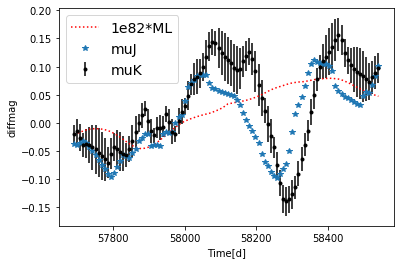

In [641]:
conv = Psitot(soln.x, XK_new, muK, muJ, sdK)

plt.errorbar(XK_new, muK, yerr=sdK, fmt=".k", capsize=0, label='muK')
plt.plot(XK_new, 1e82*conv, ":r", label="1e82*ML")
plt.plot(XK_new, muJ, '*', label="muJ")
plt.legend(fontsize=14)
#plt.xlim(58240,58290)
plt.xlabel("Time[d]")
plt.ylabel("diffmag");

In [613]:
#define the prior 

def log_prior(theta):
    sigma_DT, sigma_AD, mu_DT, mu_AD, A_T, T, wav, wav_0, K_0, index, log_f = theta
    if (0.0 < sigma_DT < 3.5 and 0.0 < sigma_AD < 3.5 and 0.0 < mu_DT < 7.0
        and 0 < mu_AD < 7.0 and 0.0 < A_T < 1.0 and np.log(1300.0) < T < np.log(2000.0) and 0.0 < wav < np.log(6000.0)
        and 0.0 < wav_0 < np.log(6000.0) and 0.0 < K_0 < 10.0 and -3.0 < index < 0.0 and -5.0 < log_f < 0.0):
        return 0.0
    return -np.inf

In [614]:
def log_probability(theta, x, y, Fc, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, Fc, yerr)

In [615]:
import emcee
#sigma_DT_val, sigma_AD_val, mu_DT_val, mu_AD_val, A_T_val, T_val, wav_val, wav_0_val, K_0_val, index_val, log_f_val = soln.x
pos = soln.x + 1e-1 * np.random.randn(100, 11)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(XK_new, muK, muJ, sdK))
sampler.run_mcmc(pos, 10000, progress=True);

C:\Users\Ejer\Anaconda3\lib\site-packages\emcee-3.0rc2-py3.7.egg\emcee\ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|██████████| 10000/10000 [03:08<00:00, 52.96it/s]


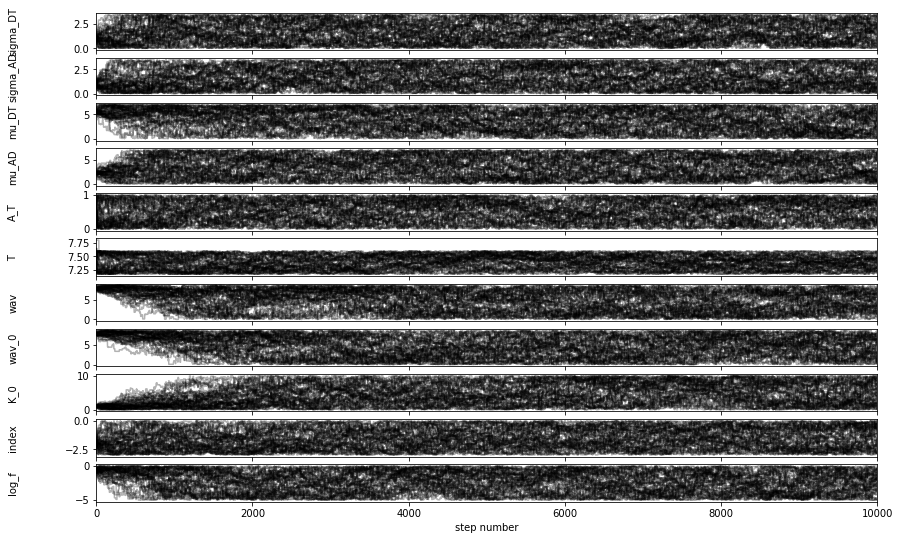

In [616]:
fig, axes = plt.subplots(11, figsize=(14, 9), sharex=True)
samples = sampler.get_chain()
labels = ["sigma_DT", "sigma_AD", "mu_DT", "mu_AD", "A_T", "T", "wav", "wav_0", "K_0", "index", "log_f"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [617]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 11 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [655.28313031 745.83133868 640.8806086  731.76407013 592.74828582
 650.77891596 699.27783253 700.81311436 746.63175133 693.53101369
 681.74346724]

In [618]:
flat_samples = sampler.get_chain(discard=1200, thin=300, flat=True)
print(flat_samples.shape)

(1450, 11)


In [619]:
planck(wav_ml,T_ml)

50096286522.72329

In [620]:
transferDT(XK_new,mu_DT_ml,sigma_DT_ml,A_T_ml,wav_ml,T_ml)

array([4.17201163e-84, 4.16104798e-84, 4.15011468e-84, 4.13921165e-84,
       4.12833878e-84, 4.11749599e-84, 4.10668321e-84, 4.09590033e-84,
       4.08514727e-84, 4.07442395e-84, 4.06373027e-84, 4.05306616e-84,
       4.04243153e-84, 4.03182628e-84, 4.02125034e-84, 4.01070363e-84,
       4.00018604e-84, 3.98969751e-84, 3.97923795e-84, 3.96880727e-84,
       3.95840539e-84, 3.94803222e-84, 3.93768769e-84, 3.92737171e-84,
       3.91708419e-84, 3.90682505e-84, 3.89659422e-84, 3.88639161e-84,
       3.87621713e-84, 3.86607071e-84, 3.85595227e-84, 3.84586172e-84,
       3.83579898e-84, 3.82576398e-84, 3.81575663e-84, 3.80577685e-84,
       3.79582456e-84, 3.78589968e-84, 3.77600214e-84, 3.76613186e-84,
       3.75628874e-84, 3.74647273e-84, 3.73668373e-84, 3.72692168e-84,
       3.71718648e-84, 3.70747807e-84, 3.69779637e-84, 3.68814130e-84,
       3.67851278e-84, 3.66891074e-84, 3.65933510e-84, 3.64978578e-84,
       3.64026271e-84, 3.63076581e-84, 3.62129501e-84, 3.61185023e-84,
      

In [621]:
power(wav_ml,wav_0_ml,K_0_ml,index_ml)

0.9793195191915959

In [622]:
transferAD(XK_new,mu_AD_ml,sigma_AD_ml,A_T_ml,wav_ml,wav_0_ml,K_0_ml,index_ml)

array([3.14313325e-99, 3.13323271e-99, 3.12336476e-99, 3.11352928e-99,
       3.10372616e-99, 3.09395529e-99, 3.08421656e-99, 3.07450986e-99,
       3.06483507e-99, 3.05519210e-99, 3.04558083e-99, 3.03600115e-99,
       3.02645295e-99, 3.01693613e-99, 3.00745058e-99, 2.99799619e-99,
       2.98857285e-99, 2.97918046e-99, 2.96981892e-99, 2.96048810e-99,
       2.95118792e-99, 2.94191827e-99, 2.93267904e-99, 2.92347012e-99,
       2.91429142e-99, 2.90514283e-99, 2.89602425e-99, 2.88693557e-99,
       2.87787669e-99, 2.86884752e-99, 2.85984794e-99, 2.85087786e-99,
       2.84193718e-99, 2.83302579e-99, 2.82414360e-99, 2.81529051e-99,
       2.80646641e-99, 2.79767121e-99, 2.78890481e-99, 2.78016711e-99,
       2.77145802e-99, 2.76277743e-99, 2.75412524e-99, 2.74550137e-99,
       2.73690571e-99, 2.72833817e-99, 2.71979866e-99, 2.71128707e-99,
       2.70280331e-99, 2.69434729e-99, 2.68591890e-99, 2.67751807e-99,
       2.66914469e-99, 2.66079867e-99, 2.65247992e-99, 2.64418834e-99,
      

In [645]:
exp = -(np.log(XK_new-mu_AD_ml)**2/(2*sigma_AD_ml**2))
print(np.exp(exp))
front = (1.0-A_T_ml)/(XK_new*sigma_AD_ml*np.sqrt(2*np.pi))
print(front)
#print(np.exp(exp)*front)

[6.76492759e-27 6.75385352e-27 6.74279908e-27 6.73176423e-27
 6.72074892e-27 6.70975313e-27 6.69877681e-27 6.68781993e-27
 6.67688245e-27 6.66596433e-27 6.65506554e-27 6.64418604e-27
 6.63332579e-27 6.62248476e-27 6.61166290e-27 6.60086020e-27
 6.59007659e-27 6.57931206e-27 6.56856656e-27 6.55784006e-27
 6.54713252e-27 6.53644391e-27 6.52577419e-27 6.51512332e-27
 6.50449126e-27 6.49387799e-27 6.48328347e-27 6.47270765e-27
 6.46215051e-27 6.45161201e-27 6.44109212e-27 6.43059079e-27
 6.42010800e-27 6.40964370e-27 6.39919787e-27 6.38877046e-27
 6.37836145e-27 6.36797080e-27 6.35759846e-27 6.34724442e-27
 6.33690863e-27 6.32659106e-27 6.31629168e-27 6.30601044e-27
 6.29574732e-27 6.28550228e-27 6.27527528e-27 6.26506630e-27
 6.25487530e-27 6.24470224e-27 6.23454710e-27 6.22440982e-27
 6.21429040e-27 6.20418878e-27 6.19410493e-27 6.18403883e-27
 6.17399043e-27 6.16395971e-27 6.15394662e-27 6.14395115e-27
 6.13397325e-27 6.12401289e-27 6.11407003e-27 6.10414465e-27
 6.09423672e-27 6.084346

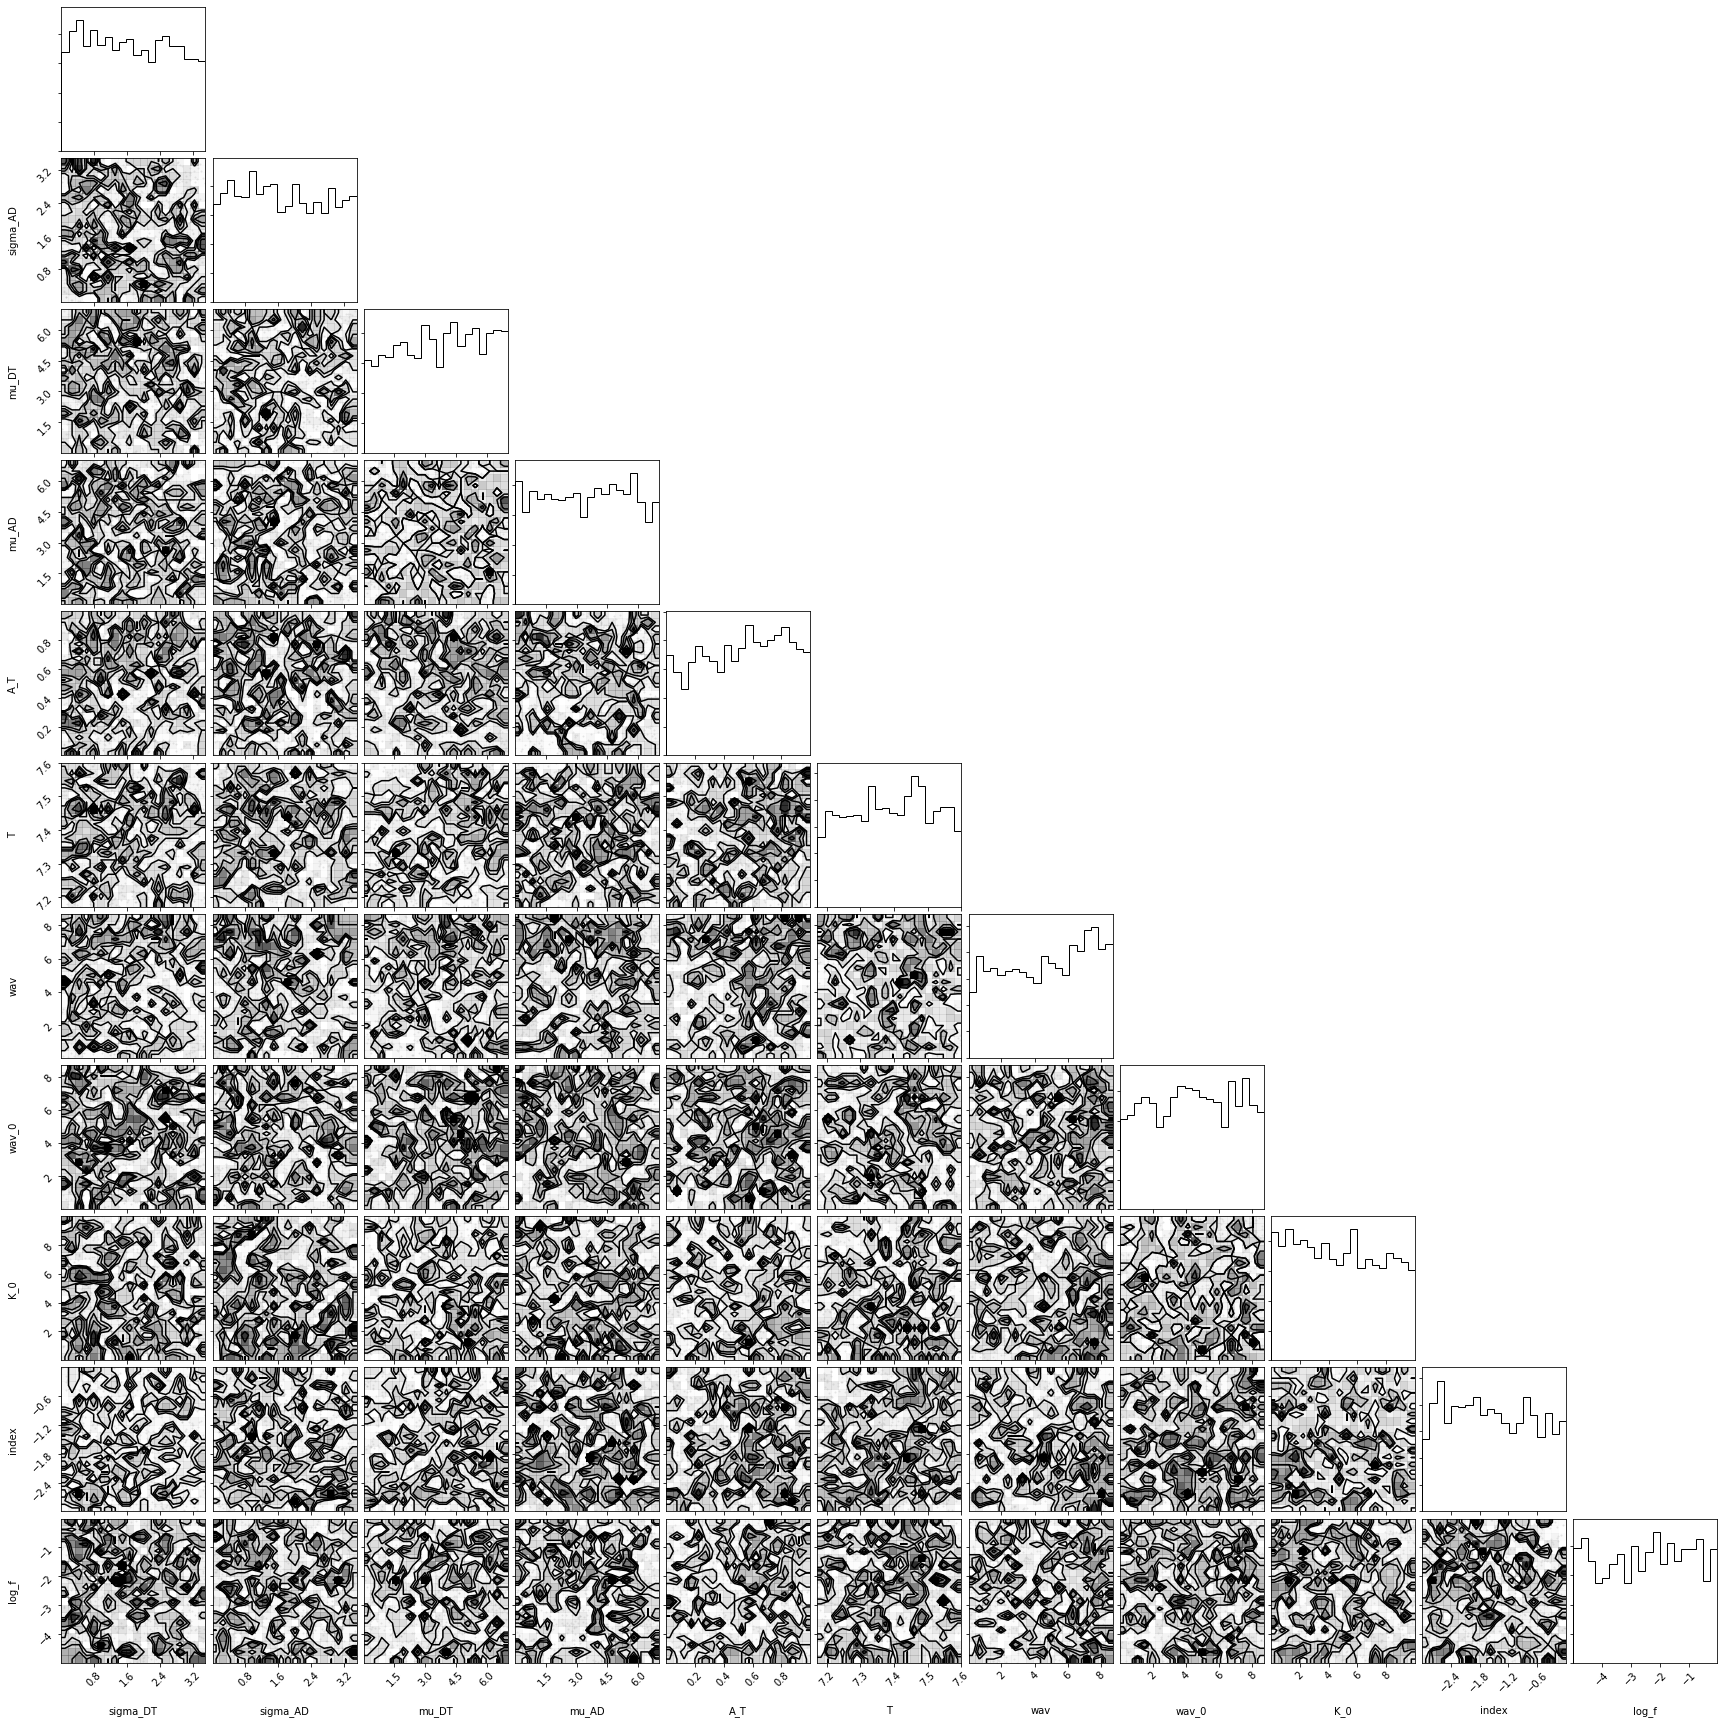

In [626]:
import corner

fig = corner.corner(
    flat_samples, labels=labels
);

In [49]:
import theano.tensor.signal.conv
from scipy import signal
xtest=np.linspace(0,10,100)
filt=2.0*xtest
conv=signal.convolve(xtest, filt, mode='full')

with pm.Model() as model:
    
    A =pm.Uniform('A',lower=0.0,upper=5.0)#pm.Normal('A', mu=2.0, sigma=2.0)
    filtt = A*xtest
    convol=theano.tensor.signal.conv.conv2d(xtest[None,:],filtt[None,:],(1,100),(1,100),border_mode='full')
    #midconvol = Middlearray(convol.tag.test_value[0], xtest)
    
    likelihood = pm.Normal('conv', mu=convol, observed=conv)

    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:43<00:00, 137.78draws/s]
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9535494666075752, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9158801371227066, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9944952848195996, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9854941890907535, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin st

mean        sd  mc_error   hpd_2.5  hpd_97.5     n_eff      Rhat
A  2.046163  0.138178  0.013802  1.999847  2.449064  7.945923  1.245964

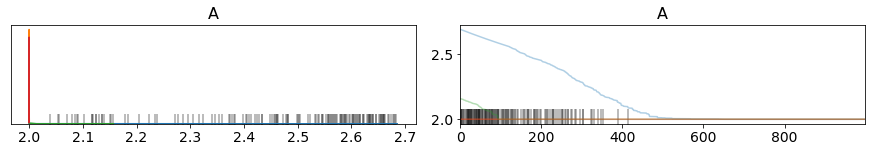

In [50]:
pm.traceplot(trace)
pm.summary(trace)

In [336]:
x = np.arange(50) * 1.
y = np.random.normal((x+0.1)/5, 1, 50)
print(y.shape)
def tophat(x, centre, width, amplitude):
    return tt.switch((x < centre + (width/2)) & (x >= centre - (width/2)), np.float64(amplitude) / width,  np.float64(0.))

import theano.tensor.signal.conv
def theano_convolve(x, y, filt_range, centre, width, amplitude):
    a = tt.dmatrix('a')
    b = tt.dmatrix('b')

    filt = tophat(b, centre, width, amplitude)

    func = tt.signal.conv.conv2d(a, filt, (1, y.shape[0]), (1, filt_range.shape[0]), border_mode='full') / filt.sum()

    return theano.function([a, b], func)(y[None, :], filt_range[None, :])

(50,)


In [4]:
from scipy import signal
from theano import shared

xtest=np.linspace(0.1,10,101)
filt=2.0*xtest
conv=signal.convolve(xtest, filt, mode='same')
#plt.plot(xtest,conv)

with pm.Model() as model:

    A = pm.Normal('A', mu=2.0, sigma=1.0)#pm.Uniform('A',lower=0.0,upper=5.0)#pm.Normal('A', mu=2.0, sigma=1.0)
    xtestT=np.reshape(xtest,(1,1,101,1))#
    #xtestT=shared(xtestT)
    filtt = A*xtestT#pm.math.dot(A,xtestT)
    convol=theano.tensor.nnet.conv2d(xtestT,filtt,border_mode='half')
    #print(convol[0,0,:,0].tag.test_value)
    #plt.plot(xtest,convol[0,0,:,0].tag.test_value)
    #print(xtestT[:,0,0,0].tag.test_value)
    #print(filtt[0,:,0,0].tag.test_value)
    likelihood = pm.Normal('conv', mu=convol[0,0,:,0], observed=conv)

    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:03<00:00, 93.78draws/s] 
The acceptance probability does not match the target. It is 0.984754953183985, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9998201931573129, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9119513563137, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9994510536455625, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


mean        sd  mc_error   hpd_2.5  hpd_97.5       n_eff      Rhat
A  2.000001  0.000051  0.000001  1.999909  2.000103  974.306787  1.000904

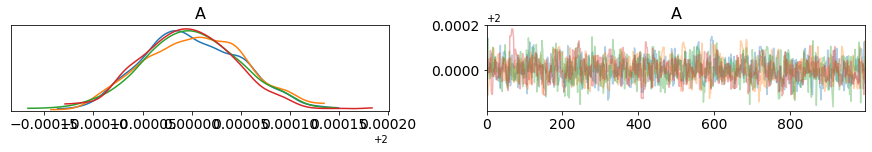

In [5]:
pm.traceplot(trace)
pm.summary(trace)

In [ ]:
import theano
import theano.tensor as tt
from scipy import signal

xtest=np.linspace(0.1,10,101)
filt=2.0*xtest
conv=signal.convolve(xtest, filt, mode='same')

with pm.Model() as model:

    A = pm.Normal('A', mu=2.0, sigma=1.0)#also works for pm.Uniform('A',lower=0.0,upper=5.0)
    
    xtestT=np.reshape(xtest,(1,1,101,1))#np.reshape(xtest,(1,1,1,101)) should also work

    filtt = A*xtestT
    
    convol=theano.tensor.nnet.conv2d(xtestT,filtt,border_mode='half')
    #'half' work the same way as 'same' for odd sized filters. 

    likelihood = pm.Normal('conv', mu=convol[0,0,:,0], observed=conv)

    trace = pm.sample(1000)